In [1]:
# reproducable randomness
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

#### PyPi Modules

In [3]:
import tensorflow as tf
import numpy as np
from keras import backend as K

Using TensorFlow backend.


#### Local Modules

In [4]:
from neural_stylization.vgg19 import VGG_19
from neural_stylization.img_util import load_image, image_to_matrix, normalize, denormalize, matrix_to_image
from neural_stylization.jupyter_plot import JupyterPlot
from keras import backend as K

# Loading Image

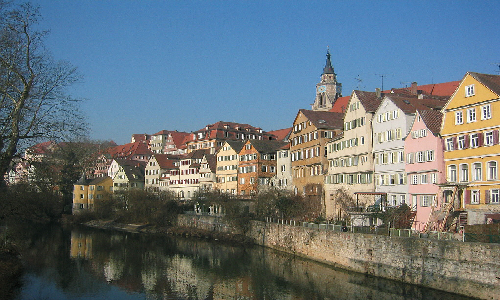

In [5]:
tubingen = load_image('img/content/tubingen.jpg', (500, 300))
tubingen

## Binary Image $\to$ 4D Tensor 

To process the image by the VGG model, we need it in a 4 dimensional
tensor of the shape schema $[frame, height, width, channel]$.

*   $frame$ indexes one of several frames passing through the network
*   $channel$ indexes the _color channel_.
    *   RGB $\implies$ 3
    *   Black and White $\implies$ 1

In [6]:
# convert the binary image data to a Numpy matrix
img = image_to_matrix(tubingen)
img.shape

(1, 300, 500, 3)

In [7]:
# calculate the mean value for each channel
means = img[0].mean(axis=0).mean(axis=0)
means

array([103.21995, 115.23705, 120.55277], dtype=float32)

In [8]:
# normalize the image by the means in the ImageNet data
img = normalize(img)
norm_means = img[0].mean(axis=0).mean(axis=0)
norm_means

array([ 16.61366  ,  -1.5420169, -20.460016 ], dtype=float32)

In [9]:
# invert the means from RGB to BGR using the [::-1] 
# then subtract from the normalized means. This should
# produce the ImageNet means: [103.939, 116.779, 123.68]
means[::-1] - norm_means

array([103.93911, 116.77907, 123.67996], dtype=float32)

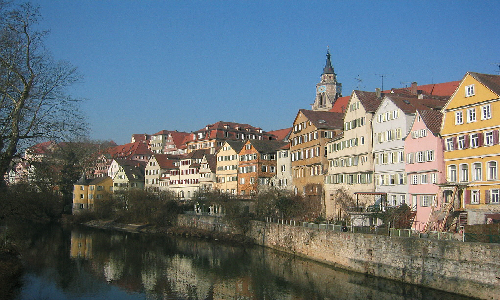

In [10]:
# validate the work by converting back to the Original
# image with no changes made
tubgingen = matrix_to_image(denormalize(img[0]))
tubingen.save('tex/img/content/tubingen.png')
tubgingen

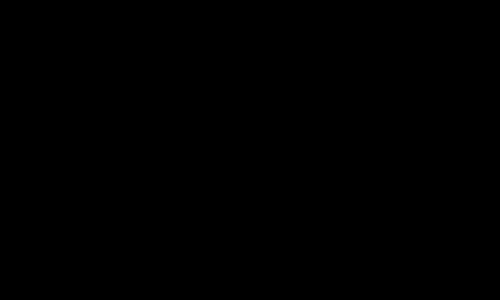

In [11]:
noise = matrix_to_image(np.random.uniform(0, 1, img.shape)[0])
noise.save('tex/img/content/noise.png')
noise

# Model

The VGG model has a few layers. Gatys et al. focus on 5 in their content reconstruction studies: 

1.  block1_conv1
1.  block2_conv1
1.  block3_conv1
1.  block4_conv1
1.  block5_conv1

The first convolutional layer from each block in the network

In [12]:
VGG_19(include_top=False).output_tensors

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/R

## Content Loss

They define the content loss for a layer $l$ as the squared euclidean distance between the
output of the content image, and the combination image for each filter in $l$.

In [13]:
def content_loss(content, combination):
    """
    Return the content loss between the content and combinations tensors.

    Args:
        content: the output of a layer for the content image
        combination: the output of a layer for the combination image

    Returns: the loss between `content` and `combination`
    """
    # squared euclidean distance, exactly how it is in the paper
    return 0.5 * K.sum(K.square(combination - content))

## Optimizing White Noise to Reconstruct Content

In [14]:
iterations = 100
learning_rate = 1e-3
layer_name = 'block4_conv2'

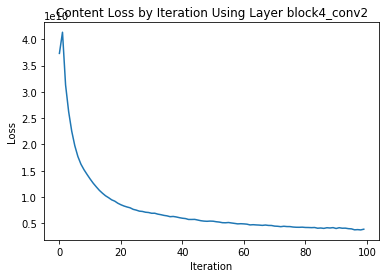

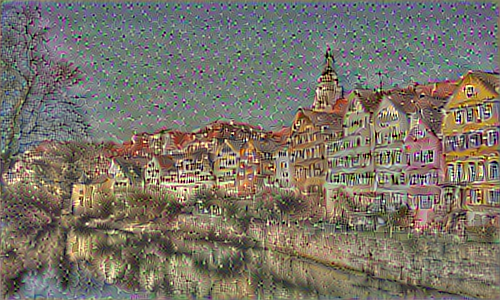

In [15]:
# load the content image into keras as a constant, it never changes
content = K.constant(img, name='Content')
# create a placeholder for the trained image, this variable trains
canvas = K.placeholder(img.shape, name='Cavnas')
# combine the content and canvas tensors along the frame axis (0) 
# into a 4D tensor of shape [2, height, width, channels]
tensor = K.concatenate([content, canvas], axis=0)
# build the model with the 4D input tensor of content and canvas
model = VGG_19(include_top=False, input_tensor=tensor, pooling='avg')

# extract the layer's out that we have interest in for reconstruction
layer = model[layer_name]

# calculate the loss between the output of the layer on the 
# content (0) and the canvas (1) 
loss = content_loss(layer[0], layer[1])

# calculate the gradients of the model inputs with respect to 
# the loss. i.e. backpropagate the loss through the network 
# to the input layer
grads = K.gradients(loss, canvas)[0]

# generate the iteration function for gradient descent optimization
# Args:
#     noise: the input to the noise placeholder in the model
#         this effectively takes a the white noise image being
#         optimized and passes it forward and backward through 
#         the model collecting the loss and gradient along the 
#         way
# 
# Returns:
#     a tuple of (loss, gradients)
#     -   loss: the content loss between the content image
#         and the white noise
#     -   gradients: the gradients of the input variables
#         with repsect to the loss
iterate = K.function([canvas], [loss, grads])

# generate random noise
noise = np.random.uniform(0, 1, img.shape)
# create a new interactive plot to visualize the loss in realtime
plot = JupyterPlot(title='Content Loss by Iteration Using Layer {}'.format(layer_name), xlabel='Iteration', ylabel='Loss')
# perform the specified iterations of gradient descent
for i in range(iterations):
    # pass the noise the canvas tensor generating the loss
    # and gradients as a tuple
    loss_i, grads_i = iterate([noise])
    # move the noise based on the gradients and learning rate
    noise -= learning_rate * grads_i
    # update the plot with the loss for this iteration
    plot(loss_i)
    
# clear out the variables from the keras session
K.clear_session()

# denormalize the image to add the mean values
# of the network back and flip the channels back
# to RGB from BGR. convert this RGB matrix to 
# an image we can look at
matrix_to_image(denormalize(noise[0]))

## Functional Decomposition

In [16]:
def reconstruct_content(content: 'Image', 
                        layer_name: str='block1_conv1',
                        learning_rate: float=1e-2,
                        iterations: int=20,
                        pooling: str='avg') -> 'Image':
    """
    Reconstruct the given content image at the given VGG19 layer.
    
    Args:
        content: the content image to reconstruct
        layer_name: the layer to reconstruct the content from
        learning_rate: the learning rate to optimize white noise
        iterations: the number of gradient descent iterations to perform
        pooling: the pooling style for the VGG19 network
        
    Returns:
        the reconstructed content image based on the VGG19 response
        at the given layer name
    """
    # load the content image into keras as a constant, it never changes
    content = K.constant(content, name='Content')
    # create a placeholder for the trained image, this variable trains
    canvas = K.placeholder(content.shape, name='Cavnas')
    # combine the content and canvas tensors along the frame axis (0) 
    # into a 4D tensor of shape [2, height, width, channels]
    tensor = K.concatenate([content, canvas], axis=0)
    # build the model with the 4D input tensor of content and canvas
    model = VGG_19(include_top=False, input_tensor=tensor, pooling=pooling)

    # extract the layer's out that we have interest in for reconstruction
    layer = model[layer_name]

    # calculate the loss between the output of the layer on the 
    # content (0) and the canvas (1) 
    loss = content_loss(layer[0], layer[1])

    # calculate the gradients of the model inputs with respect to 
    # the loss. i.e. backpropagate the loss through the network 
    # to the input layer
    grads = K.gradients(loss, canvas)[0]

    # generate the iteration function for gradient descent optimization
    # Args:
    #     noise: the input to the noise placeholder in the model
    #         this effectively takes a the white noise image being
    #         optimized and passes it forward and backward through 
    #         the model collecting the loss and gradient along the 
    #         way
    # 
    # Returns:
    #     a tuple of (loss, gradients)
    #     -   loss: the content loss between the content image
    #         and the white noise
    iterate = K.function([canvas], [loss, grads])

    # generate random noise
    noise = np.random.uniform(0, 1, content.shape)
    # perform the specified iterations of gradient descent
    for i in range(iterations):
        # pass the noise the canvas tensor generating the loss
        # and gradients as a tuple
        loss_i, grads_i = iterate([noise])
        # move the noise based on the gradients and learning rate
        noise -= learning_rate *grads_i

    # clear the current tensorflow session
    K.clear_session()
    
    # denormalize the image to add the mean values
    # of the network back and flip the channels back
    # to RGB from BGR. convert this RGB matrix to 
    # an image we can look at
    return matrix_to_image(denormalize(noise[0]))

## Visualization of all 5 Gatys et al. Content Layers

In [17]:
# a dictionary of some values found quickly by experimentation to
# visualize the response at each layer. the layer names themself
# come directly from the paper.
gatys_layers = [
    ('block1_conv1', 200, 2e-2),
    ('block2_conv1', 200, 2e-3),
    ('block3_conv1', 200, 2e-3),
    ('block4_conv1', 200, 1e-3),
    ('block5_conv1', 200, 1e-1)
]

'block1_conv1'

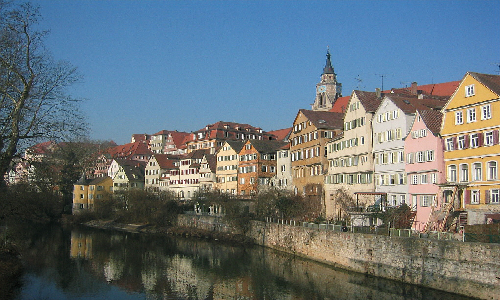

'block2_conv1'

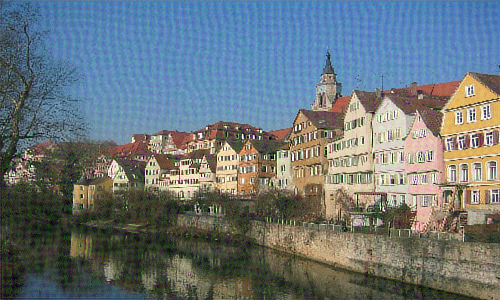

'block3_conv1'

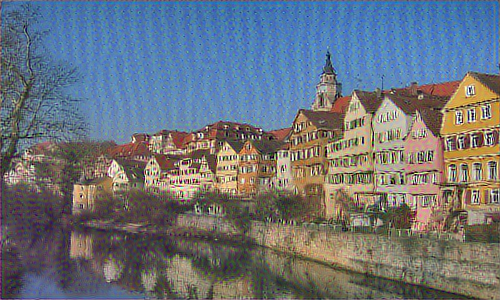

'block4_conv1'

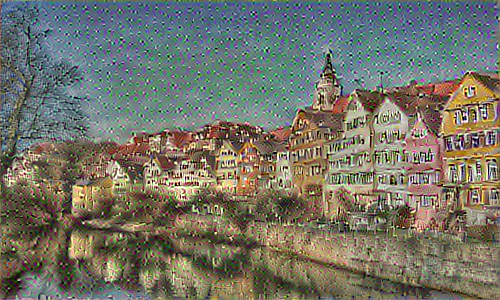

'block5_conv1'

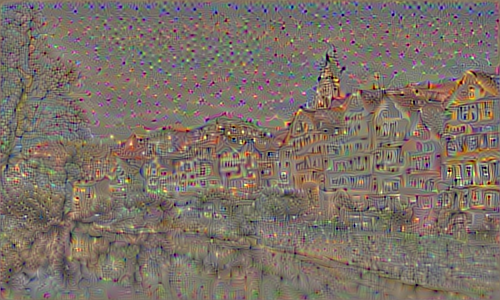

In [18]:
from IPython.display import display

# iterate over the layers and their hyperparameters
for gatys_layer in gatys_layers:
    # unpack the hyperparameters
    layer_name, iterations, learning_rate = gatys_layer
    # generate a reconstructed image with the model
    rec = reconstruct_content(img, layer_name, learning_rate, iterations)
    # display the layer name
    display(layer_name)
    # display the reconstructed image
    display(rec)
    # save the image to disk
    rec.save('tex/img/content/{}.png'.format(layer_name))

'block4_conv2'

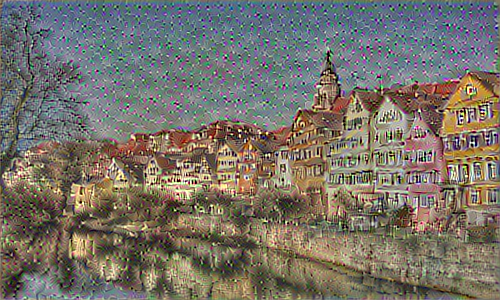

In [19]:
layer_name = 'block4_conv2'
# generate a reconstructed image with the model
rec = reconstruct_content(img, layer_name, 1e-3, 200)
# display the layer name
display(layer_name)
# display the reconstructed image
display(rec)
# save the image to disk
rec.save('tex/img/content/{}.png'.format(layer_name))